In [314]:
# Data analysis and manipulation
import pandas as pd
import numpy as np

# Data Viz
import seaborn as sns
import matplotlib.pyplot as plt

# Datetime
import datetime

# Machine Learning
from sklearn.model_selection import train_test_split

# Misc
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 300)

In [315]:
housing_data = pd.read_csv("C:/algernon_ka_nook/ml_projects/udemy/price-prediction/kc_house_data.csv")
print(housing_data.head(10))
print(housing_data.shape)

           id             date      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15
0  7129300520  20141013T000000   221900.0         3       1.00         1180      5650     1.0           0     0          3      7        1180              0      1955             0    98178  47.5112 -122.257           1340        5650
1  6414100192  20141209T000000   538000.0         3       2.25         2570      7242     2.0           0     0          3      7        2170            400      1951          1991    98125  47.7210 -122.319           1690        7639
2  5631500400  20150225T000000   180000.0         2       1.00          770     10000     1.0           0     0          3      6         770              0      1933             0    98028  47.7379 -122.233           2720        8062
3  2487200875  20141209T000000   604000.0         4       3.

### <b>Steps to follow:</b>
<i>

* Understand the business requirements and the nature of the available data.

* Classify the problem as supervised/unsupervised and regression/classification.

* Download, clean & explore the data and create new features that may improve models.

* Create training/test/validation sets and prepare the data for training ML models.

* Create a quick & easy baseline model to evaluate and benchmark future models.

* Pick a modeling strategy, train a model, and tune hyperparameters to achieve optimal fit.

* Experiment and combine results from multiple strategies to get a better result.

* Interpret models, study individual predictions, and present findings.
</i>

Problem Statement: Predict property prices, based on property info like bathrooms, sqft_lot, floors etc.
Problem Classification: Property price are continous in nature so this is a regression problem.

0        221900
1        538000
2        180000
3        604000
4        510000
          ...  
21608    360000
21609    400000
21610    402101
21611    400000
21612    325000
Name: price, Length: 21613, dtype: int32


count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

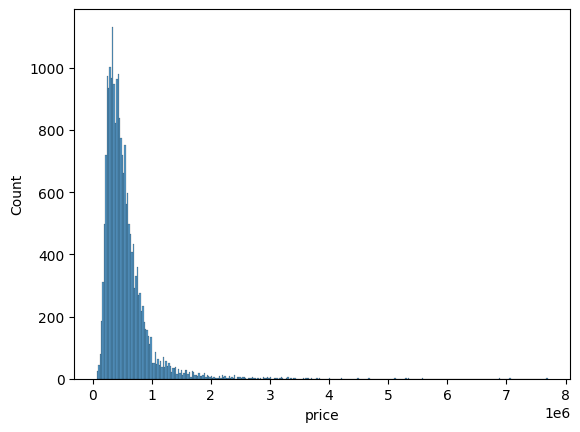

In [316]:
# Remove Outliers
housing_data['price'] = housing_data['price'].astype(int)
print(housing_data['price'])
# sns.distplot(housing_data['price'])
sns.histplot(housing_data['price'])
housing_data['price'].describe()

(21613, 21)


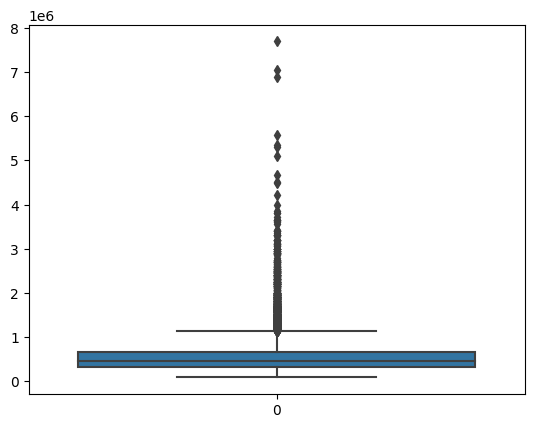

In [317]:
# columns = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','grade','sqft_above','sqft_basement','sqft_living15','sqft_lot15']
# for f in columns:
#     sns.boxplot(housing_data[f])

sns.boxplot(housing_data['price'])
print(housing_data.shape)

What did I understood?

- Skewed data for price -> IQR to be implemented

In [318]:
print(housing_data['price'].value_counts().sort_values())

print(housing_data['bathrooms'].unique())

529100      1
135900      1
629800      1
689950      1
839950      1
         ... 
425000    150
500000    152
550000    159
450000    172
350000    172
Name: price, Length: 4028, dtype: int64
[1.   2.25 3.   2.   4.5  1.5  2.5  1.75 2.75 3.25 4.   3.5  0.75 4.75
 5.   4.25 3.75 0.   1.25 5.25 6.   0.5  5.5  6.75 5.75 8.   7.5  7.75
 6.25 6.5 ]


In [319]:
def remove_outliers(df, feature):
  percentile25 = df[feature].quantile(0.25)
  percentile75 = df[feature].quantile(0.75)
  iqr = percentile75 - percentile25
  upper_limit = percentile75 + 1.5 * iqr
  lower_limit = percentile25 - 1.5 * iqr
  outliers = df[(df[feature] > upper_limit) | (df[feature] < lower_limit)]
  new_df = df[(df[feature] >= lower_limit) & (df[feature] <= upper_limit)]
  return new_df

columns = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','grade','sqft_above','sqft_basement','sqft_living15','sqft_lot15']
for f in columns:
  housing_data = remove_outliers(housing_data, f)

print(housing_data.shape)

(14609, 21)


In [320]:
# sns.boxplot(housing_data['price'])

In [321]:
# Missing Data

housing_data.isnull().sum().sort_values(ascending = False)
housing_data.info()
print("No null values found in the dataset")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14609 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             14609 non-null  int64  
 1   date           14609 non-null  object 
 2   price          14609 non-null  int32  
 3   bedrooms       14609 non-null  int64  
 4   bathrooms      14609 non-null  float64
 5   sqft_living    14609 non-null  int64  
 6   sqft_lot       14609 non-null  int64  
 7   floors         14609 non-null  float64
 8   waterfront     14609 non-null  int64  
 9   view           14609 non-null  int64  
 10  condition      14609 non-null  int64  
 11  grade          14609 non-null  int64  
 12  sqft_above     14609 non-null  int64  
 13  sqft_basement  14609 non-null  int64  
 14  yr_built       14609 non-null  int64  
 15  yr_renovated   14609 non-null  int64  
 16  zipcode        14609 non-null  int64  
 17  lat            14609 non-null  float64
 18  long  

In [322]:
# Feature Engineering

### New Features:
#### total_sqft = sqft_living + sqft_basement
#### built age of property = current year - yr built
#### last renovation age = current year - yr renovated
#### price per sqft living

In [323]:
housing_data['total_sqft'] = housing_data['sqft_living'] + housing_data['sqft_basement']
housing_data['price_per_property'] = housing_data['price']/housing_data['total_sqft'] 
housing_data['yr_built'] = housing_data['yr_built'].astype(int)
housing_data['yr_renovated'] = housing_data['yr_renovated'].astype(int)

housing_data['age_of_property'] = np.where(housing_data['yr_built'] == 0, 0, datetime.datetime.now().year - housing_data['yr_built'])
housing_data['age_of_renovation'] = np.where(housing_data['yr_renovated'] == 0, 0, datetime.datetime.now().year - housing_data['yr_renovated'])

In [324]:
# print(housing_data[['price','age_of_property']].sort_values(ascending = False, by = 'age_of_property').head(20))

In [325]:
# Encoding
print("No categorical data present, no encoding required")

No categorical data present, no encoding required


In [326]:
housing_data = housing_data.apply(pd.to_numeric, errors='coerce')
target_column = "price"
correlations = {}

# Calculate correlations
for col in housing_data.columns:
    if col != target_column:
        correlation = housing_data[target_column].corr(housing_data[col])
        correlations[col] = correlation


for col, corr in correlations.items():
    print(f"Correlation between {target_column} and {col}: {corr}")


# data_correlations = pd.DataFrame(correlations, index=['Value']).T
# data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

Correlation between price and id: 0.03552671658028681
Correlation between price and date: nan
Correlation between price and bedrooms: 0.20770278293298264
Correlation between price and bathrooms: 0.32165517564562734
Correlation between price and sqft_living: 0.4798881806269441
Correlation between price and sqft_lot: -0.12286940673935735
Correlation between price and floors: 0.215888978859219
Correlation between price and waterfront: nan
Correlation between price and view: nan
Correlation between price and condition: 0.0914810407839613
Correlation between price and grade: 0.49774676676509994
Correlation between price and sqft_above: 0.356722380936902
Correlation between price and sqft_basement: 0.22358007263293866
Correlation between price and yr_built: -0.08529018876513289
Correlation between price and yr_renovated: 0.10652660338915436
Correlation between price and zipcode: 0.02887780320181189
Correlation between price and lat: 0.49845567184238193
Correlation between price and long: -0.

<Axes: >

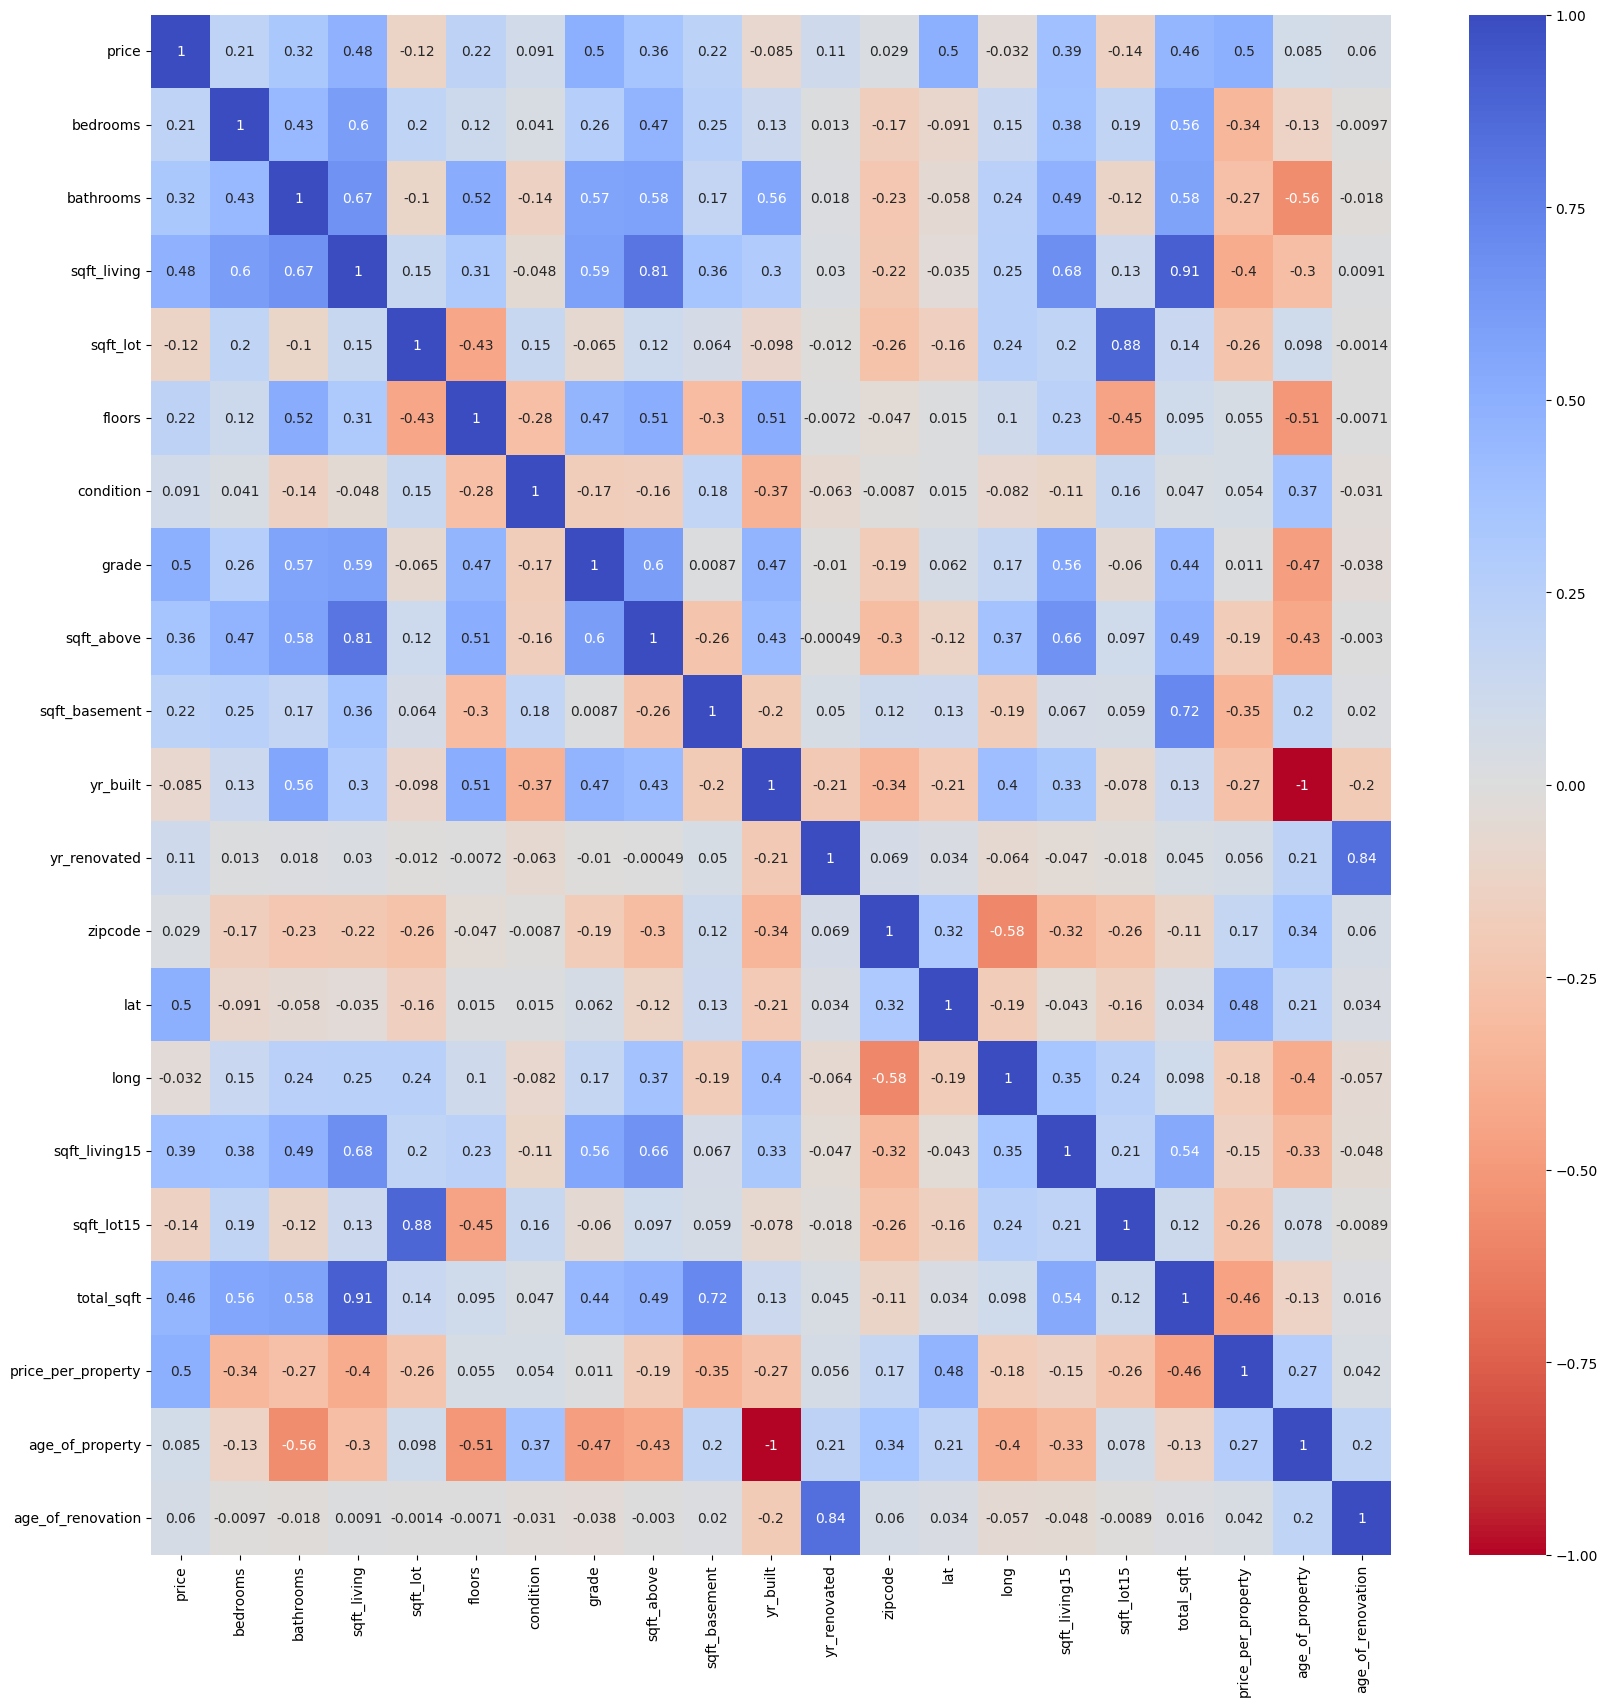

In [327]:
# Correlation Matrix
# Exclude 'waterfront', 'view', 'id', 'date' columns from the DataFrame
columns_to_exclude = ['waterfront', 'view','id','date']
filtered_housing_data = housing_data.drop(columns=columns_to_exclude)

cor = filtered_housing_data.corr()
plt.figure(figsize = (20,20))
sns.heatmap(cor, annot = True, cmap='coolwarm_r')


In [328]:
print("Highly correlated features are:\n")
print("1. price & total_sqft\n")
print("2. price & price_per_property\n")
print("3. price & sqft_living15\n")
print("4. price & grade\n")
print("5. price & bathrooms\n")
print("6. price & bedrooms\n")
print("Features with no correlation with price: waterfront, view, date")

Highly correlated features are:

1. price & total_sqft

2. price & price_per_property

3. price & sqft_living15

4. price & grade

5. price & bathrooms

6. price & bedrooms

Features with no correlation with price: waterfront, view, date


In [329]:
# drop unnecessary columns
cols = ['date', 'id','view','waterfront']
housing_data.drop(columns=cols, axis=1, inplace=True)

In [330]:
housing_data.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'total_sqft', 'price_per_property', 'age_of_property', 'age_of_renovation'], dtype='object')

In [331]:
# Splitting Training, Validation, and Test Dataset
data = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'total_sqft', 'price_per_property', 'age_of_property', 'age_of_renovation']
target = ['price']

housing_train, housing_test, price_train, price_test = train_test_split(housing_data[data], housing_data[target], test_size=0.2, random_state=42)
housing_train, housing_val, price_train, price_val = train_test_split(housing_train, price_train, test_size=0.2, random_state=42)
print(housing_train.shape)
print(housing_test.shape)
print(housing_val.shape)

(9349, 20)
(2922, 20)
(2338, 20)


In [332]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluating Models
models = {
    "linear_regressor": LinearRegression(),
    "decision_regressor": DecisionTreeRegressor(),
    "rf_regressor": RandomForestRegressor(),
    "xgboost_regressor": XGBRegressor()
}

for model_name, model in models.items():
    model.fit(housing_train, price_train)

    # Predict for training, testing, and validation datasets
    price_train_pred = model.predict(housing_train)
    price_test_pred = model.predict(housing_test)
    price_val_pred = model.predict(housing_val)

    mae_train = mean_absolute_error(price_train, price_train_pred)
    mse_train = mean_squared_error(price_train, price_train_pred)
    r2_train = r2_score(price_train, price_train_pred)

    mae_test = mean_absolute_error(price_test, price_test_pred)
    mse_test = mean_squared_error(price_test, price_test_pred)
    r2_test = r2_score(price_test, price_test_pred)

    mae_val = mean_absolute_error(price_val, price_val_pred)
    mse_val = mean_squared_error(price_val, price_val_pred)
    r2_val = r2_score(price_val, price_val_pred)

    print(f"Model: {model_name}")

    print("Training Scores:")
    print(f"MAE: {mae_train:.2f}")
    print(f"MSE: {mse_train:.2f}")
    print(f"R-squared: {r2_train:.2f}")
    print("----------------------------")
    print("Testing Scores:")
    print(f"MAE: {mae_test:.2f}")
    print(f"MSE: {mse_test:.2f}")
    print(f"R-squared: {r2_test:.2f}")
    print("----------------------------")
    print("Validation Scores:")
    print(f"MAE: {mae_val:.2f}")
    print(f"MSE: {mse_val:.2f}")
    print(f"R-squared: {r2_val:.2f}")

    print()

Model: linear_regressor
Training Scores:
MAE: 43453.82
MSE: 3621218857.44
R-squared: 0.88
----------------------------
Testing Scores:
MAE: 44788.81
MSE: 3740861993.16
R-squared: 0.88
----------------------------
Validation Scores:
MAE: 43925.41
MSE: 3662132051.54
R-squared: 0.88



Model: decision_regressor
Training Scores:
MAE: 0.00
MSE: 0.00
R-squared: 1.00
----------------------------
Testing Scores:
MAE: 10884.67
MSE: 349711640.29
R-squared: 0.99
----------------------------
Validation Scores:
MAE: 11166.22
MSE: 382359436.84
R-squared: 0.99

Model: rf_regressor
Training Scores:
MAE: 2093.09
MSE: 18323843.59
R-squared: 1.00
----------------------------
Testing Scores:
MAE: 5474.99
MSE: 141470547.58
R-squared: 1.00
----------------------------
Validation Scores:
MAE: 5090.99
MSE: 100368344.22
R-squared: 1.00

Model: xgboost_regressor
Training Scores:
MAE: 4827.71
MSE: 40823018.19
R-squared: 1.00
----------------------------
Testing Scores:
MAE: 9721.91
MSE: 186525861.53
R-squared: 0.99
----------------------------
Validation Scores:
MAE: 9666.92
MSE: 184236184.16
R-squared: 0.99

CPU times: total: 22 s
Wall time: 19.4 s


# Model Evaluation

Linear Regressor:<br>
Observation: The linear regressor performs reasonably well with good R-squared values on both the testing and validation sets. <br>
It has relatively low MAE and MSE. <br>

Decision Tree Regressor:<br>
Observation: The decision tree regressor performs exceptionally well on the training set, achieving a perfect R-squared of 1.00. <br>
However, it exhibits a significant drop in performance on the testing and validation sets, indicating potential overfitting.<br>

Random Forest Regressor:
Observation: The random forest regressor performs well with low MAE, MSE, and high R-squared values on all datasets. <br>
It shows good generalization from the training to testing and validation sets.<br>

XGBoost Regressor:<br>
Observation: The XGBoost regressor performs well with low MAE and MSE values, as well as high R-squared values. <br>
It exhibits good generalization on testing and validation datasets.<br>

Based on these observations:<br>
The Decision Tree Regressor has the best training performance, achieving a perfect R-squared score and lowest MAE and MSE. <br>
However, it shows signs of overfitting, as its performance drops significantly on the testing and validation sets.<br>
The Random Forest Regressor and XGBoost Regressor perform well on all datasets and appear to have better generalization compared to the Decision Tree Regressor.<br>
The Linear Regressor also performs reasonably well, with good R-squared values and lower MAE and MSE compared to the Decision Tree Regressor.<br>

# Possible methods to reduce overfitting

Cross-Validation: Use cross-validation techniques (e.g., k-fold cross-validation) to assess your model's performance on different subsets of the training data. Cross-validation helps you identify whether your model is overfitting by providing a more robust estimate of its generalization performance. <br>

More Data: Collect more training data if possible. A larger dataset can help the model learn more robust patterns and reduce the chances of overfitting.<br>

Feature Selection: Carefully choose relevant features and remove irrelevant or redundant ones. Feature selection reduces the complexity of the model and can mitigate overfitting.<br>

Feature Engineering: Create new features or transform existing ones to make them more informative. Proper feature engineering can help the model capture essential patterns while reducing overfitting.<br>

Simpler Models: Choose simpler models with fewer parameters. Complex models (e.g., deep neural networks) are more prone to overfitting. Consider using linear models, decision trees with depth constraints, or simpler algorithms when applicable.<br>

Hyperparameter Tuning: Experiment with different hyperparameters (e.g., learning rate, regularization strength, tree depth) using techniques like grid search or random search. Finding the right hyperparameters can help balance model complexity and performance.<br>

Ensemble Methods: Combine predictions from multiple models, such as Random Forests or Gradient Boosting, to reduce overfitting. Ensemble methods often perform well because they leverage the collective wisdom of multiple models.<br>


# Hyperparameter Refinement of Decision Trees using trial and error

In [350]:
%%time
def test_params_dt(**params):
    # Train-validation split
    housing_train, housing_test, price_train, price_test = train_test_split(housing_data[data], housing_data[target], test_size=0.2, random_state=42)
    housing_train, housing_val, price_train, price_val = train_test_split(housing_train, price_train, test_size=0.2, random_state=42)
    decision_regressor = DecisionTreeRegressor(random_state=42, **params).fit(housing_train, price_train)
    price_train_pred = decision_regressor.predict(housing_train)
    price_val_pred = decision_regressor.predict(housing_val)
    return r2_score(price_train, price_train_pred), r2_score(price_val, price_val_pred), mean_absolute_error(price_train, price_train_pred), mean_absolute_error(price_val, price_val_pred), mean_squared_error(price_train, price_train_pred), mean_squared_error(price_val, price_val_pred)

print("Parameter max_depth = 100 gives accuracy:", test_params_dt(max_depth=50)) 
print("Parameter min_samples_split = 2 gives accuracy:", test_params_dt(min_samples_split=2)) 
print("Parameter min_samples_leaf = 2 gives accuracy:", test_params_dt(min_samples_leaf=2)) 
print("Parameter max_features = None gives accuracy:", test_params_dt(max_features=None)) 
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
print("Final Tuned R2 score, MAE, MSE for decision tree:", test_params_dt(max_depth=100, min_samples_split=2, min_samples_leaf=2, max_features=None))

Parameter max_depth = 100 gives accuracy: (1.0, 0.9891895447913359, 0.0, 10889.40119760479, 0.0, 336886779.5808383)
Parameter min_samples_split = 2 gives accuracy: (1.0, 0.9891895447913359, 0.0, 10889.40119760479, 0.0, 336886779.5808383)
Parameter min_samples_leaf = 2 gives accuracy: (0.9993168331810783, 0.9882443588655573, 2393.8144186544014, 10937.080553179356, 21226218.476468068, 366341657.8902671)
Parameter max_features = None gives accuracy: (1.0, 0.9891895447913359, 0.0, 10889.40119760479, 0.0, 336886779.5808383)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Final Tuned R2 score, MAE, MSE for decision tree: (0.9993168331810783, 0.9882443588655573, 2393.8144186544014, 10937.080553179356, 21226218.476468068, 366341657.8902671)
CPU times: total: 938 ms
Wall time: 1.48 s


Initial Model (Before Hyperparameter Tuning):<br>

Training R-squared: 1.00<br>
Testing R-squared: 0.99<br>
Validation R-squared: 0.99<br>
In the initial model, the training R-squared is perfect (1.00), indicating that the model fits the training data perfectly. However, the testing and validation R-squared values are slightly lower, suggesting some overfitting as the model does not generalize as well to unseen data.<br>

After Hyperparameter Tuning through trial and error:<br>

Final Tuned Training R-squared: 0.9993<br>
Final Tuned Validation R-squared: 0.9882<br>
After hyperparameter tuning, you can see that the training R-squared is still high but not perfect (0.9993), and the validation R-squared is also high (0.9882). These values are very close, indicating that the model now generalizes better to unseen data (validation set) without overfitting as much as the initial model.<br>

0.9993168331810783, 0.9882443588655573,

# Hyperparameter Tuning using GridSearch and RandomSearch

In [360]:
# Function to tune hyperparameters using GridSearchCV and RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def tune_hyperparameters(model, param_grid_gs, param_grid_rs, x_train, y_train, cv_gs, cv_rs, n_iter):

    # GridSearchCV
    grid_search = GridSearchCV(model, param_grid_gs, cv=cv_gs, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(housing_train, price_train)

    # Best hyperparameters
    best_params_grid = grid_search.best_params_
    best_model_grid = grid_search.best_estimator_

    # RandomizedSearchCV
    random_search = RandomizedSearchCV(model, param_grid_rs, n_iter=n_iter, cv=cv_rs, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    random_search.fit(housing_train, price_train)

    # Best hyperparameters
    best_params_random = random_search.best_params_
    best_model_random = random_search.best_estimator_

    # Making predictions on the validation data using the best grid search model
    price_val_pred_grid = best_model_grid.predict(housing_val)

    # Making predictions on the validation data using the best randomized search model
    price_val_pred_random = best_model_random.predict(housing_val)

    # Calculate precision, recall, and F1-Score for the grid search model
    r2_val_grid = r2_score(price_val, price_val_pred_grid)
    mae_val_grid = mean_absolute_error(price_val, price_val_pred_grid)
    mse_val_grid = mean_squared_error(price_val, price_val_pred_grid)

    # Calculate precision, recall, and F1-Score for the randomized search model
    r2_val_random = r2_score(price_val, price_val_pred_random)
    mae_val_random = mean_absolute_error(price_val, price_val_pred_random)
    mse_val_random = mean_squared_error(price_val, price_val_pred_random)

    return (
        best_params_grid, best_params_random, r2_val_grid, mae_val_grid, mse_val_grid, r2_val_random, mae_val_random, mse_val_random
    )

In [362]:
%%time
# Define the model
decision_regressor = DecisionTreeRegressor(random_state=42)

# GridSearchCV Parameters
param_grid_gs = {
    'max_depth': [100, 500],
    'min_samples_leaf': [2, 3, 4],
    'max_features': [None],
    'min_samples_split': [2, 3, 4]
}

# RandomizedSearchCV Parameters
param_grid_rs = {
  "max_depth": [100, 200, 500],
  'min_samples_leaf': [2, 3, 4],
  'max_features': [None],
  'min_samples_split': [2, 3, 4],
  "splitter": ["best", "random"]
  }

# Train-validation split
housing_train, housing_test, price_train, price_test = train_test_split(housing_data[data], housing_data[target], test_size=0.2, random_state=42)
housing_train, housing_val, price_train, price_val = train_test_split(housing_train, price_train, test_size=0.2, random_state=42)
decision_regressor = DecisionTreeRegressor()

# Call the function with the defined model and hyperparameter grid
best_params_grid, best_params_random, r2_val_grid, mae_val_grid, mse_val_grid, r2_val_random, mae_val_random, mse_val_random = tune_hyperparameters(decision_regressor, param_grid_gs, param_grid_rs, housing_train, price_train, cv_gs = 5, cv_rs = 2, n_iter = 2)

# Print the results
print("GridSearchCV - Best hyperparameters:", best_params_grid)
print("RandomizedSearchCV - Best hyperparameters:", best_params_random)
print("")
print(f"Decision Tree Model R2 in Validation df (Grid Search): {r2_val_grid:.7f}")
print(f"Decision Tree Model MAE in Validation df (Grid Search): {mae_val_grid:.7f}")
print(f"Decision Tree Model MSE in Validation df (Grid Search): {mse_val_grid:.7f}")
print("")
print(f"Decision Tree Model R2 in Validation df (Random Search): {r2_val_random:.7f}")
print(f"Decision Tree Model MAE in Validation df (Random Search): {mae_val_random:.7f}")
print(f"Decision Tree Model MSE in Validation df (Random Search): {mse_val_random:.7f}")

GridSearchCV - Best hyperparameters: {'max_depth': 500, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2}
RandomizedSearchCV - Best hyperparameters: {'splitter': 'random', 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 200}

Decision Tree Model R2 in Validation df (Grid Search): 0.9890484
Decision Tree Model MAE in Validation df (Grid Search): 10890.9493228
Decision Tree Model MSE in Validation df (Grid Search): 341284717.6149769

Decision Tree Model R2 in Validation df (Random Search): 0.8922391
Decision Tree Model MAE in Validation df (Random Search): 34483.9527374
Decision Tree Model MSE in Validation df (Random Search): 3358157636.9077201
CPU times: total: 688 ms
Wall time: 3.39 s


# Final Insights

Grid Search has outperformed and reduced overfitting. It appears to have performed better in terms of improving model performance on the validation dataset compared to RandomizedSearchCV.

# Feature Importance of best model


Feature importance is a concept used in machine learning to determine the significance or contribution of individual features (variables or columns) in a predictive model. <br>
It provides insights into which features are the most influential in making predictions.<br>
Once you have selected the best model, you can then visualize the feature importance. <br>
Feature importance helps you understand which features had the most impact on the model's predictions. <br>
This information is valuable for interpreting the model's behavior and can be useful for feature selection or domain understanding.

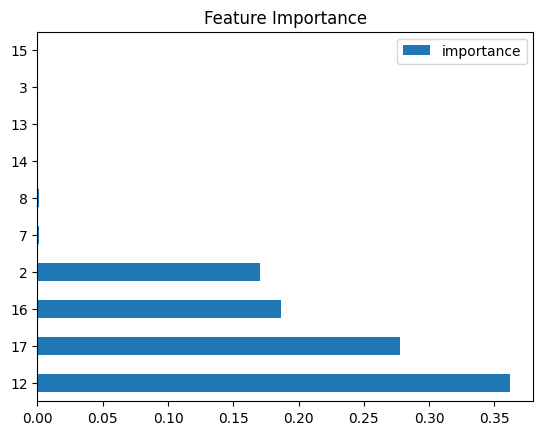

               feature  importance
12                 lat       36.18
17  price_per_property       27.77
16          total_sqft       18.63
2          sqft_living       17.01
7           sqft_above        0.15
8        sqft_basement        0.08
14       sqft_living15        0.02
13                long        0.02
3             sqft_lot        0.02
15          sqft_lot15        0.02
11             zipcode        0.02
18     age_of_property        0.01
9             yr_built        0.01
1            bathrooms        0.01
19   age_of_renovation        0.01
0             bedrooms        0.01
5            condition        0.01
4               floors        0.00
6                grade        0.00
10        yr_renovated        0.00


In [364]:
# Visualizing Feature Importance of the best model
decision_regressor.fit(housing_train, price_train)

importance_df = pd.DataFrame({'feature': housing_train.columns, 'importance': decision_regressor.feature_importances_}).sort_values(by = 'importance', ascending=False)
importance_df.nlargest(10, 'importance').plot(kind='barh')
plt.title('Feature Importance')
plt.show()

importance_df['importance'] = importance_df['importance'] * 100
importance_df['importance'] = importance_df['importance'].round(2)
print(importance_df)

High Importance (>=1.0): Features with high importance scores are considered crucial by the model in making accurate predictions. <br>
These features have a strong influence on the target variable, and changes in these features will significantly impact the model's output. <br>
In feature importance plots, these features will appear at the top.<br>

Low Importance (close to 0.0): Features with low importance scores have minimal impact on the model's predictions. <br>
The model doesn't rely heavily on these features to make decisions. Changes in these features are unlikely to have a significant effect on the model's output. <br>
In feature importance plots, these features will appear at the bottom.

Zero Importance (0.0): If a feature has an importance score of 0.0, it means that the feature was not used at all by the model when making predictions. <br>
The model considers this feature irrelevant or does not benefit from including it in the decision-making process.<br>

The importance of the "lat" feature in predicting housing prices can be attributed to its strong correlation with the target variable (housing prices) and its significance in determining a property's location. <br>
"lat" typically represents the latitude or geographical north-south position of a property.<br>
In real estate, location is often considered one of the most critical factors influencing property prices. <br>
Certain neighborhoods or areas may be more desirable due to factors such as proximity to schools, parks, shopping centers, or scenic views. <br>
Buyers are willing to pay more for properties in desirable locations.<br>

# Save the model and make predictions on new unseen data

In [366]:
# Sample New Unseen Data
columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade',
           'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
           'sqft_living15', 'sqft_lot15', 'total_sqft', 'price_per_property', 'age_of_property', 'age_of_renovation']
new_data = pd.DataFrame(columns=columns)
new_data['bedrooms'] = [3, 4, 3, 3]  
new_data['bathrooms'] = [2.5, 2.25, 1.0, 1.0]
new_data['sqft_living'] = [1750, 2000, 1300, 1500]
new_data['sqft_lot'] = [7000, 4000, 8000, 6000]
new_data['floors'] = [1.0, 2.0, 1.0, 1.0]
new_data['condition'] = [4, 3, 5, 3]
new_data['grade'] = [8, 7, 6, 7]
new_data['sqft_above'] = [1500, 1800, 1100, 1200]
new_data['sqft_basement'] = [250, 200, 200, 300]
new_data['yr_built'] = [1990, 1985, 2000, 1995]
new_data['yr_renovated'] = [0, 0, 0, 0]
new_data['zipcode'] = [98001, 98102, 98003, 98104]
new_data['lat'] = [47.6, 47.7, 47.8, 47.9]
new_data['long'] = [-122.1, -122.2, -122.3, -122.4]
new_data['sqft_living15'] = [1600, 1800, 1400, 1600]
new_data['sqft_lot15'] = [6000, 3500, 7000, 5000]
new_data['total_sqft'] = [2000, 2200, 1500, 1800]
new_data['price_per_property'] = [300, 350, 250, 320]
new_data['age_of_property'] = [32, 37, 22, 28]
new_data['age_of_renovation'] = [0, 0, 0, 0]
print(new_data)

   bedrooms  bathrooms  sqft_living  sqft_lot  floors  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode   lat   long  sqft_living15  sqft_lot15  total_sqft  price_per_property  age_of_property  age_of_renovation
0         3       2.50         1750      7000     1.0          4      8        1500            250      1990             0    98001  47.6 -122.1           1600        6000        2000                 300               32                  0
1         4       2.25         2000      4000     2.0          3      7        1800            200      1985             0    98102  47.7 -122.2           1800        3500        2200                 350               37                  0
2         3       1.00         1300      8000     1.0          5      6        1100            200      2000             0    98003  47.8 -122.3           1400        7000        1500                 250               22                  0
3         3       1.00         1500     

In [375]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [373]:
import joblib  # or import pickle to save the model

# Save the trained model to a file
joblib.dump(decision_regressor, 'decision_regressor.pkl')

# Load the trained model
model = joblib.load('decision_regressor.pkl')  

# Make predictions on the test data
predictions = model.predict(new_data)

print("Predicted Prices:\n", predictions)

new_data_with_predictions = new_data.copy()
new_data_with_predictions['price_predicted'] = predictions

print("New Predicted Dataframe:\n", new_data_with_predictions)

Predicted Prices:
 [625000. 765000. 400000. 590000.]
New Predicted Dataframe:
    bedrooms  bathrooms  sqft_living  sqft_lot  floors  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode   lat   long  sqft_living15  sqft_lot15  total_sqft  price_per_property  age_of_property  age_of_renovation  price_predicted
0         3       2.50         1750      7000     1.0          4      8        1500            250      1990             0    98001  47.6 -122.1           1600        6000        2000                 300               32                  0         625000.0
1         4       2.25         2000      4000     2.0          3      7        1800            200      1985             0    98102  47.7 -122.2           1800        3500        2200                 350               37                  0         765000.0
2         3       1.00         1300      8000     1.0          5      6        1100            200      2000             0    98003  47.8 -122.3      